# Курсовой проект для курса "Python для Data Science"

### Задание:

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Метрика качества:

R2 - коэффициент детерминации (sklearn.metrics.r2_score) > 0.6

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')

plt.rc('font', **font)
warnings.filterwarnings('ignore')

#### Загрузим данные

In [43]:
data = pd.read_csv('train.csv')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [45]:
data = data.set_index('Id')
data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [44]:
cleared_data = data.fillna(0)

#### Датафреймы X и Y

In [46]:
X = cleared_data.drop(labels=['Price'], axis=1)
X = pd.get_dummies(data=X, columns=['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'], drop_first=True)
y = cleared_data['Price'].values

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [48]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

#### Соберем данные r2_score

In [52]:
models_list = [LinearRegression, KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor]

def get_r2_score(model):
    model_instance = model()
    model_instance.fit(X_train_scaled, y_train)
    y_pred_train = model_instance.predict(X_train_scaled)
    y_pred_valid = model_instance.predict(X_valid_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_valid = r2_score(y_valid, y_pred_valid)
    return score_train, score_valid
    
r2_scores = list(map(get_r2_score, models_list))

In [51]:
for model, scores in zip(models_list, r2_scores):
    print('{}:\n\ttrain: {}\n\tvalid: {}'.format(
        model.__name__,
        np.round(scores[0], 4),
        np.round(scores[1], 4)
    ))

LinearRegression:
	train: 0.6573
	valid: 0.6184
KNeighborsRegressor:
	train: 0.7467
	valid: 0.5918
DecisionTreeRegressor:
	train: 1.0
	valid: 0.4706
RandomForestRegressor:
	train: 0.9619
	valid: 0.7347


#### Распределение цены

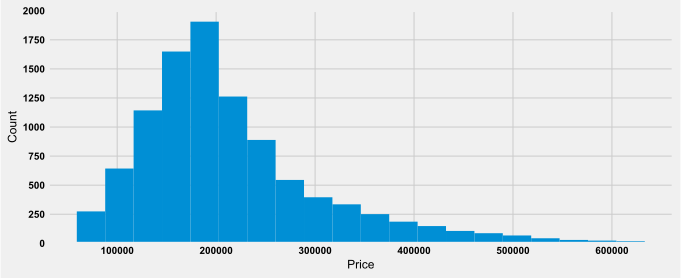

In [49]:
plt.figure(figsize=(10, 4))
data.Price.hist(bins=20)
plt.ylabel("Count")
plt.xlabel("Price")
plt.show()

#### Распределение комнат

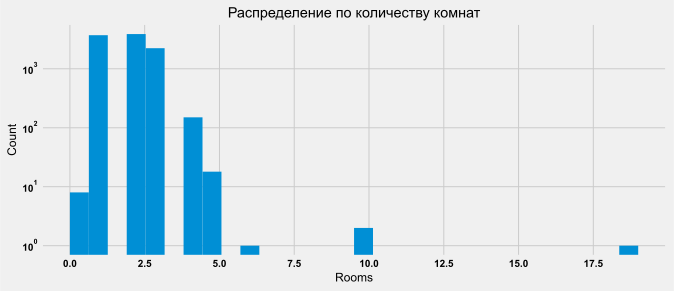

In [50]:
plt.figure(figsize=(10, 4))
data.Rooms.hist(bins=30, log=True)
plt.ylabel("Count")
plt.xlabel("Rooms")
plt.title("Распределение по количеству комнат")
plt.show()

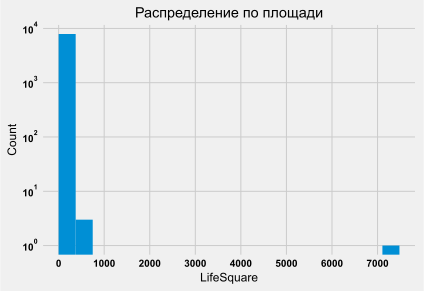

In [23]:
data.LifeSquare.hist(bins=10, log=True)
plt.ylabel("Count")
plt.xlabel("LifeSquare")
plt.title("Распределение по площади")
plt.show()

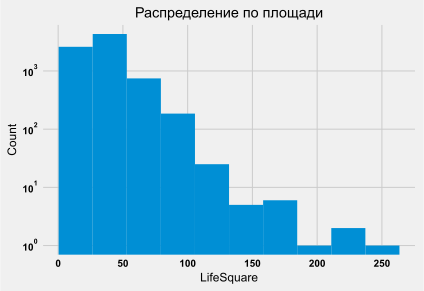

In [54]:
data = data[data.LifeSquare < 300]

data.LifeSquare.hist(bins=10, log=True)
plt.ylabel("Count")
plt.xlabel("LifeSquare")
plt.title("Распределение по площади")
plt.show()

In [25]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,7883.000000,7883.000000,7883.000000,7883.000000,7883.000000,7883.000000,7883.000000,7.883000e+03,7883.000000,7883.000000,7883.000000,7883.000000,4454.000000,7883.000000,7883.000000,7883.000000
mean,56.668020,1.920208,55.108761,36.077983,7.583154,8.153622,12.437270,4.529528e+03,0.122546,28.481796,6098.094761,7.257897,1211.289178,1.521375,4.528986,223417.129200
std,45.353639,0.856103,18.909000,18.014430,32.010862,5.087124,6.367496,2.258235e+05,0.120089,16.650923,3908.871010,19.629804,1068.457816,1.517100,4.426256,94939.354314
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,22.000000,1.000000,41.167264,22.767925,5.000000,4.000000,9.000000,1.971000e+03,0.025609,19.000000,3681.000000,1.000000,325.000000,0.000000,1.000000,162075.391139
50%,46.000000,2.000000,50.833326,32.767366,7.000000,7.000000,12.000000,1.979000e+03,0.081943,28.000000,5664.000000,2.000000,1015.000000,1.000000,4.000000,200014.336149
75%,88.000000,3.000000,64.683348,45.107755,9.000000,11.000000,17.000000,2.004000e+03,0.194489,38.000000,7759.000000,5.000000,1894.000000,3.000000,6.000000,262296.554087
max,209.000000,19.000000,275.645284,263.542020,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625678.644994


#### Значение 0 в min. Приводим к среднему

In [26]:
data_copy = data.fillna(0)

In [55]:
def preprocess_data(data_in):
    preprocessed_data = data_in.copy()
    
    idx = (preprocessed_data['HouseYear'] >= 2019)
    preprocessed_data.loc[idx, 'HouseYear'] = 2019
    
    square_median = dict(preprocessed_data.groupby('Rooms')['Square'].median())
    idx = (preprocessed_data['Rooms'] == 0)
    preprocessed_data.loc[idx, 'Rooms'] = preprocessed_data.loc[idx, 'Rooms'].\
        apply(lambda x: square_median[x])
    
    square_median = dict(preprocessed_data.groupby('Rooms')['Square'].median())
    idx = (preprocessed_data['Square'] < 15) & (preprocessed_data['Rooms'] < 2)
    preprocessed_data.loc[idx, 'Square'] = preprocessed_data.loc[idx, 'Rooms'].apply(lambda x: square_median[x])
    
    kitchen_square = dict(preprocessed_data.groupby('Rooms')['KitchenSquare'].median())
    idx = (preprocessed_data['Rooms'] > 0)
    preprocessed_data.loc[idx, 'KitchenSquare'] = preprocessed_data.loc[idx, 'Rooms'].apply(lambda x: kitchen_square[x])
    
    idx = (preprocessed_data['HouseFloor'] == 0)
    preprocessed_data.loc[idx, 'HouseFloor'] = preprocessed_data.loc[idx, 'HouseFloor'].apply(lambda x: 1)
    
    # Переведем поля Ecology_2, Ecology_3 и Shops_2 в числовые

    preprocessed_data['Ecology_2'] = preprocessed_data['Ecology_2'].apply(lambda x: 1 if x == 'A' else 0)
    preprocessed_data['Ecology_3'] = preprocessed_data['Ecology_3'].apply(lambda x: 1 if x == 'A' else 0)
    preprocessed_data['Shops_2'] = preprocessed_data['Shops_2'].apply(lambda x: 1 if x == 'A' else 0)
    return preprocessed_data

In [56]:
data_copy = preprocess_data(data_copy)

X = data_copy.drop(labels=['DistrictId', 'Price'], axis=1)
y = data_copy['Price'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,
714,2.0,48.168751,30.867261,6.0,5,5.0,1963,0.036122,0,0,24,4378,0,1036.0,1,1,0
14874,1.0,34.884511,21.298503,7.0,5,9.0,1970,0.309479,0,0,35,7715,4,990.0,0,6,0
5248,2.0,45.235459,29.449073,6.0,3,5.0,1971,0.033494,0,0,66,10573,1,1322.0,3,8,0
14472,3.0,104.898559,55.606246,8.0,4,27.0,2014,0.111627,0,0,50,12238,8,1970.0,2,3,0
1084,2.0,36.935115,23.381895,6.0,9,9.0,1965,0.188784,0,0,31,6137,4,0.0,0,1,0


In [29]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [30]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
random_grid = {
    'n_estimators': np.arange(200, 501, 20),
    'max_depth': np.arange(2, 51, 2),
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [57]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [32]:
random_search.fit(X_train_scaled, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
0.6934984286204813
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 26}


In [33]:
y_pred_train = random_search.best_estimator_.predict(X_train_scaled)
y_pred_valid = random_search.best_estimator_.predict(X_valid_scaled)

score_train = r2_score(y_train, y_pred_train)
score_valid = r2_score(y_valid, y_pred_valid)

print('train: {}\nvalid: {}'.format(
    np.round(score_train, 4),
    np.round(score_valid, 4)
))

train: 0.9319
valid: 0.6947


#### Обучим модель

In [34]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
rf_model = RandomForestRegressor(**random_search.best_params_)

rf_model.fit(X_scaled, y)

scores = cross_val_score(rf_model, X_scaled, y, scoring='r2', cv=10, n_jobs=-1)
 (scores), 4)))
print('cv std:  {}'.format(np.round(np.std(scores), 4)))

cv mean: 0.7036
cv std:  0.0305


In [35]:
test_data = pd.read_csv('test.csv', index_col=0, encoding='utf-8')
test_data = test_data.fillna(0)
test_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,0.0,0,0,A
960,27,2.0,59.463678,0.000000,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,0.0,0,1,B
3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,0.0,0,0,B
746,74,1.0,53.837056,0.000000,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [36]:
preprocessed_test_data = preprocess_data(test_data)
X_test = preprocessed_test_data.drop(labels=['DistrictId'], axis=1)
X_test_scaled = scaler.transform(X_test)

In [37]:
y_pred_test = rf_model.predict(X_test_scaled)

In [58]:
predictions = pd.DataFrame({
    'Id': X_test.index,
    'Price': y_pred_test
})

In [59]:
predictions.head()

,Id,Price
0,4567,161638.539041
1,5925,121823.120133
2,960,147584.310186
3,3848,122525.435992
4,746,226157.377254


In [60]:
predictions.to_csv('NovikovDV_predictions.csv', sep=',', index=False, encoding='utf-8')